# starchID Innovationsprojekt CAS machine learning

This workbook documents the development of a CNN for the classification of microscopic starch images.

# Imports 

In [1]:
import os
import time
import urllib
import requests
import random
import numpy as np
import sys
import array as arr
from urllib.parse import quote

from sklearn.metrics import confusion_matrix
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 

import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

# Define some basics: Image size, class numbers, class names

In [2]:
# The target image size can be fixed here (quadratic)
image_size = 250

# Nummber of classes
num_classes = 10

# Class names (in order)
class_names = ["Amorphophallus", "Fritillaria_th", "Ipomoea", "Kartoffel",
               "Kastanie", "Kichererbse", "Lotus", "Mais", "Reis", "Weizen"]

## Define plotting function

In [3]:
# Shortcut for displaying images
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()

# Test datagen / data augmentation: brightness + custom noise and random orthogonal rotation, 

In [4]:
# add noise and orthogonal rotation as preprocessing_function
def add_noise_ortho(img):
    VARIABILITY = 20
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.rot90(img, np.random.choice([-1, 0, 1, 2])) #rotate 0, 90, 180 or 270 degs
    np.clip(img, 0., 255.)
    return img


# Prepare data-augmenting data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.6,1.4],
        preprocessing_function=add_noise_ortho
)

## demonstratable datagen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 1 images belonging to 10 classes.


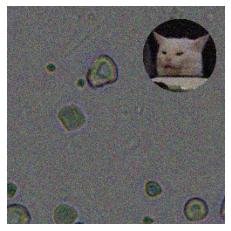

array([0.], dtype=float32)

In [5]:
dir_iter = train_datagen.flow_from_directory('./datagen_test/', 
                                         target_size=(image_size, image_size),
                                         classes=class_names,
                                         batch_size=1, class_mode='sparse', shuffle=False)

plot_img(dir_iter[0][0][0,...])
dir_iter[0][1]

### Purge memory in case of dead kernel (CUDA bug?)

In [108]:
#### CLEAR GPU MEMORY
#from tensorflow.keras import backend as K
#K.clear_session()
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

# Approach: Train end to end with a frozen convolutional base (adopted from course script)

## Import VGG16 for transfer learning (the convolutional base)

In [6]:
vgg16 = applications.VGG16(include_top=False, # top will be custom
                           weights='imagenet',
                           input_shape=(image_size,image_size,3))


### Summarize net

In [7]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0     

## Freeze convolutional base

In [9]:
print('This is the number of trainable weights '
     'before freezing the conv base:', len(model_freeze_conv.trainable_weights))

vgg16.trainable = False

print('This is the number of trainable weights '
     'after freezing the conv base:', len(model_freeze_conv.trainable_weights))


This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


## Adding a densely connected classifier on top of the convolutional base

In [8]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

model_freeze_conv = models.Sequential()
model_freeze_conv.add(vgg16)
model_freeze_conv.add(layers.Flatten())
model_freeze_conv.add(layers.Dense(256, activation = 'relu'))
model_freeze_conv.add(layers.Dense(num_classes, activation = 'softmax'))

This is what the model looks like now:

In [10]:
model_freeze_conv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 21,140,042
Trainable params: 6,425,354
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
# predict_generator requires compilation
model_freeze_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If we ever modify weight trainability after compilation, we should then recompile the model, or these changes will be ignored.

Now, we can start training our model, with the same data-augmentation configuration that we used in the previous example.

# Give it a first shot to see if it could work

In [12]:
image_size = 250
batch_size = 64
num_train_images = 20736
num_valid_images = 5184
num_classes = 10

class_names = ["Amorphophallus", "Fritillaria_th", "Ipomoea", "Kartoffel",
               "Kastanie", "Kichererbse", "Lotus", "Mais", "Reis", "Weizen"]

# prepare data augmentation configuration
# add noise and orthogonal rotation as preprocessing_function
def add_noise_ortho(img):
    VARIABILITY = 20
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.rot90(img, np.random.choice([-1, 0, 1, 2])) #rotate 0, 90, 180 or 270 degs
    np.clip(img, 0., 255.)
    return img


# Prepare data-augmenting data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.6,1.4],
        preprocessing_function=add_noise_ortho
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train',
        shuffle = True,
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
        './validation',
        target_size=(image_size, image_size),
        shuffle = True,
        classes=class_names,
        batch_size=batch_size)

model_freeze_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_freeze_conv.summary()

Found 20940 images belonging to 10 classes.
Found 5235 images belonging to 10 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 21,140,042
Trainable params: 6,425,354
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
name = 'starchID'

tensorboard_2 = TensorBoard(
        log_dir='./tensorboard/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [168]:
epochs = 15

history=model_freeze_conv.fit_generator(
        train_generator,
        steps_per_epoch=num_train_images // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_valid_images // batch_size,
        callbacks=[tensorboard_2])

Epoch 1/15
324/324 [==============================] - 377s 1s/step - loss: 0.4198 - accuracy: 0.8456 - val_loss: 0.6915 - val_accuracy: 0.7483
Epoch 2/15
324/324 [==============================] - 372s 1s/step - loss: 0.4054 - accuracy: 0.8527 - val_loss: 0.7064 - val_accuracy: 0.7458
Epoch 3/15
324/324 [==============================] - 311s 960ms/step - loss: 0.3903 - accuracy: 0.8576 - val_loss: 0.6488 - val_accuracy: 0.7672
Epoch 4/15
324/324 [==============================] - 267s 824ms/step - loss: 0.3832 - accuracy: 0.8589 - val_loss: 0.6811 - val_accuracy: 0.7633
Epoch 5/15
324/324 [==============================] - 265s 818ms/step - loss: 0.3877 - accuracy: 0.8549 - val_loss: 0.8890 - val_accuracy: 0.7294
Epoch 6/15
324/324 [==============================] - 257s 795ms/step - loss: 0.3682 - accuracy: 0.8617 - val_loss: 0.6335 - val_accuracy: 0.7760
Epoch 7/15
324/324 [==============================] - 255s 788ms/step - loss: 0.3790 - accuracy: 0.8593 - val_loss: 0.5997 - val_a

In [16]:
model_freeze_conv.save('starchID_model_freze_conv_unstopped')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: starchID_model_freze_conve_unstopped\assets


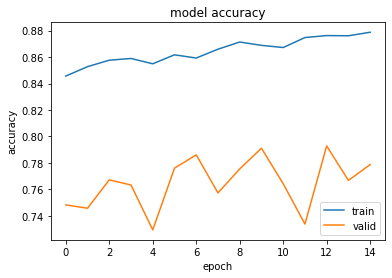

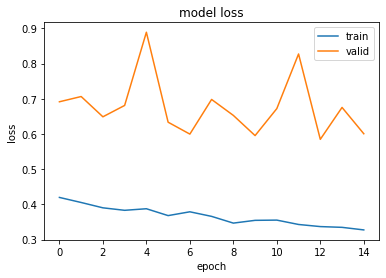

In [169]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

# grad CAM using VGG16 as feature extractor

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [7]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import cv2 # if not installed, execute : !pip install opencv-python
# Local path to the target image
#img_path = './african-elephant.jpg'
img_path = "./test/Kastanie/Kastanie_00389_crop_0.tif"
image_orig = cv2.imread(img_path)
print(image_orig.shape)

# Python Imaging Library (PIL) image of size 224x224
img = image.load_img(img_path, target_size=(250,250))

# float32 Numpy array of shape (224,224,3)
x = image.img_to_array(img)

# Adds a dimension to transform the array into a batch of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
print(x.shape)

# Preprocess the batch (this does activation-map-wise color normalization)
x = preprocess_input(x)

(500, 500, 3)
(1, 250, 250, 3)


In [8]:
preds = model.predict(x)
print('Predicted', decode_predictions(preds, top=5)[0])

Predicted [('n03920288', 'Petri_dish', 0.23627563), ('n09229709', 'bubble', 0.12252371), ('n04332243', 'strainer', 0.038188726), ('n04557648', 'water_bottle', 0.037395965), ('n04209239', 'shower_curtain', 0.034362167)]


In [9]:
np.argmax(preds[0])

712

In [10]:
# initialize the model to be VGG16
Model = VGG16

# load the pre-trained CNN from disk
print("[INFO] loading model...")
model = Model(weights="imagenet")



# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
# !pip install opencv-python-headless
import cv2
from PIL import Image

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")  

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1) 
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        #(w, h) = (image.shape[2], image.shape[1])
        heatmap = cam.numpy()
        #heatmap = cv2.resize(cam_num, (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

[INFO] loading model...


In [11]:
index_true_class = np.argmax(preds[0])
print(index_true_class)
cam = GradCAM(model, index_true_class)
heatmap = cam.compute_heatmap(x)
print(heatmap.shape)


# uses cv2 to load the original image
img = cv2.imread(img_path) 
# resizes the heatmap to be the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# applies the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 0.4 is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img
added_image = cv2.addWeighted(img,1,heatmap,0.3,0)

712
(7, 7)


# Example: Amorphophallus

Predicted Classes (VGG16) [[('n03920288', 'Petri_dish', 0.1517094), ('n04074963', 'remote_control', 0.1264407), ('n02992529', 'cellular_telephone', 0.050347716), ('n09229709', 'bubble', 0.040170915), ('n04209239', 'shower_curtain', 0.032372292)]]


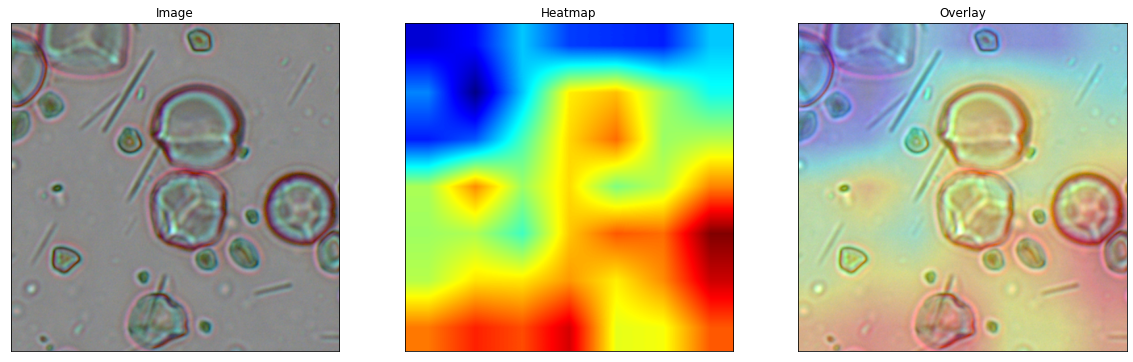

In [130]:
plt.figure(figsize = (20,15))
plt.subplot(131),plt.imshow(img),plt.title('Image')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(heatmap),plt.title('Heatmap')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(added_image),plt.title('Overlay')
plt.xticks([]), plt.yticks([])
print('Predicted Classes (VGG16)', decode_predictions(preds, top=5))

# Example: Lotus

Predicted Classes (VGG16) [[('n09229709', 'bubble', 0.2560017), ('n04125021', 'safe', 0.04306958), ('n04372370', 'switch', 0.0360585), ('n01930112', 'nematode', 0.033100594), ('n02988304', 'CD_player', 0.025821114)]]


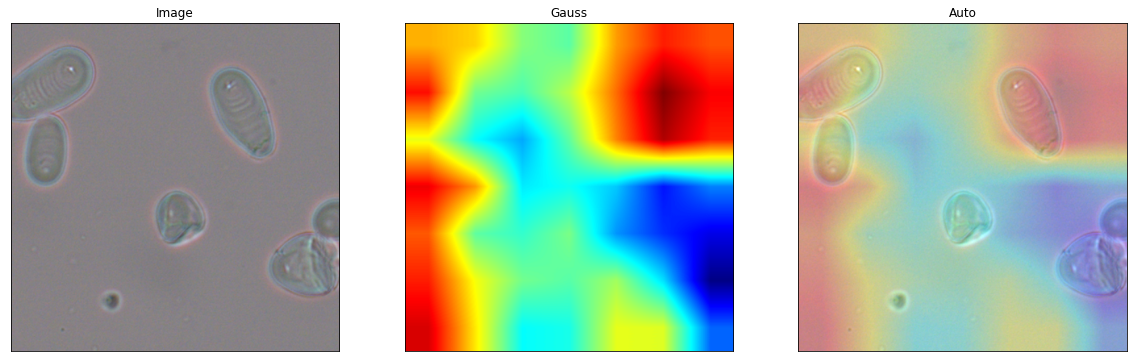

In [136]:
plt.figure(figsize = (20,15))
plt.subplot(131),plt.imshow(img),plt.title('Image')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(heatmap),plt.title('Heatmap')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(added_image),plt.title('Overlay')
plt.xticks([]), plt.yticks([])
print('Predicted Classes (VGG16)', decode_predictions(preds, top=5))

# Example: Kastanie

Predicted Classes (VGG16) [[('n03920288', 'Petri_dish', 0.23627563), ('n09229709', 'bubble', 0.12252371), ('n04332243', 'strainer', 0.038188726), ('n04557648', 'water_bottle', 0.037395965), ('n04209239', 'shower_curtain', 0.034362167)]]


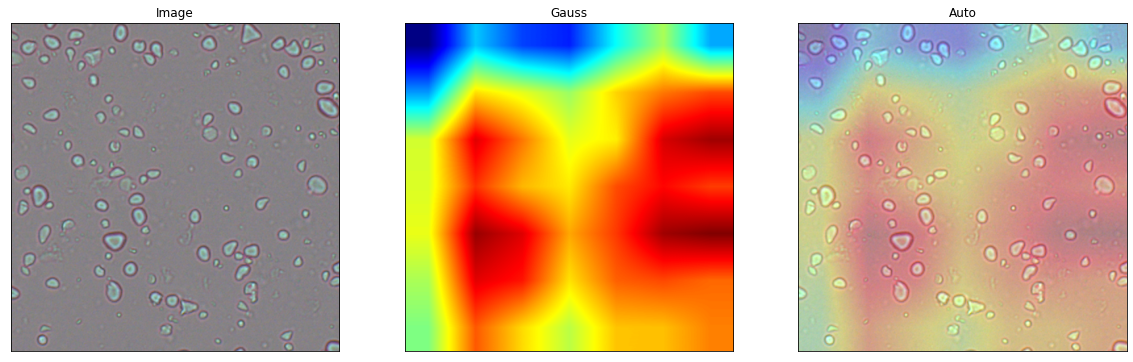

In [12]:
plt.figure(figsize = (20,15))
plt.subplot(131),plt.imshow(img),plt.title('Image')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(heatmap),plt.title('Heatmap')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(added_image),plt.title('Overlay')
plt.xticks([]), plt.yticks([])
print('Predicted Classes (VGG16)', decode_predictions(preds, top=5))

#  Sample images predicted as Nematode, Bubble, Shower curtain, water bottle by VGG16! :-)

- Categories appear to be similar enough to starch granules justifying the use of this approach (freezing conv_base)

# Playing around with batch size and subsets of training data

## Testing influence of batch size (2, 4, 8, 16, 32, 64)

Found 20940 images belonging to 10 classes.
Found 5235 images belonging to 10 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 21,140,042
Trainable params: 6,425,354
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/40
10368/10368 [==============================] - 253s 24ms/step - loss: 1.2111 - accuracy: 0.5581 - val_loss: 0.9153 - val_accuracy: 0.6

2592/2592 [==============================] - 266s 103ms/step - loss: 0.5072 - accuracy: 0.8152 - val_loss: 0.7024 - val_accuracy: 0.7496
Epoch 11/40
2592/2592 [==============================] - 265s 102ms/step - loss: 0.4760 - accuracy: 0.8268 - val_loss: 0.6602 - val_accuracy: 0.7616
Epoch 12/40
2592/2592 [==============================] - 253s 97ms/step - loss: 0.4793 - accuracy: 0.8261 - val_loss: 0.6393 - val_accuracy: 0.7693
Epoch 13/40
2592/2592 [==============================] - 245s 94ms/step - loss: 0.4740 - accuracy: 0.8260 - val_loss: 0.7127 - val_accuracy: 0.7514
Epoch 14/40
2592/2592 [==============================] - 246s 95ms/step - loss: 0.4494 - accuracy: 0.8380 - val_loss: 0.8680 - val_accuracy: 0.7116
Epoch 15/40
2592/2592 [==============================] - 242s 93ms/step - loss: 0.4540 - accuracy: 0.8347 - val_loss: 0.6874 - val_accuracy: 0.7635
Epoch 16/40
2592/2592 [==============================] - 243s 94ms/step - loss: 0.4376 - accuracy: 0.8395 - val_loss: 0.76

648/648 [==============================] - 246s 380ms/step - loss: 0.3363 - accuracy: 0.8779 - val_loss: 0.7377 - val_accuracy: 0.7496
Epoch 27/40
648/648 [==============================] - 244s 377ms/step - loss: 0.3341 - accuracy: 0.8762 - val_loss: 0.6586 - val_accuracy: 0.7822
Epoch 28/40
648/648 [==============================] - 243s 375ms/step - loss: 0.3172 - accuracy: 0.8823 - val_loss: 0.8048 - val_accuracy: 0.7407
Epoch 29/40
648/648 [==============================] - 244s 377ms/step - loss: 0.3246 - accuracy: 0.8788 - val_loss: 0.8015 - val_accuracy: 0.7510
Epoch 30/40
648/648 [==============================] - 244s 377ms/step - loss: 0.3205 - accuracy: 0.8797 - val_loss: 0.9823 - val_accuracy: 0.7193
Epoch 31/40
648/648 [==============================] - 245s 378ms/step - loss: 0.3167 - accuracy: 0.8840 - val_loss: 0.8323 - val_accuracy: 0.7328
Epoch 32/40
648/648 [==============================] - 245s 379ms/step - loss: 0.3128 - accuracy: 0.8837 - val_loss: 0.6766 - val_

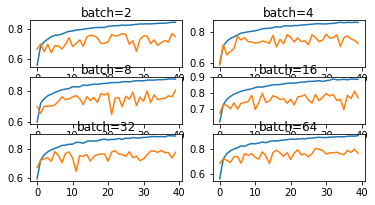

In [7]:
from matplotlib import pyplot

batch_sizes = [2, 4, 8, 16, 32, 64]

def add_noise_ortho(img):
    VARIABILITY = 20
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.rot90(img, np.random.choice([-1, 0, 1, 2])) #rotate 0, 90, 180 or 270 degs
    np.clip(img, 0., 255.)
    return img



for i in range(len(batch_sizes)):
	# determine the plot number
	plot_no = 420 + (i+1)
	pyplot.subplot(plot_no)
	vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                               input_shape=(image_size,image_size,3))

	vgg16.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

	vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

	model_freeze_conv = models.Sequential()
	model_freeze_conv.add(vgg16)
	model_freeze_conv.add(layers.Flatten())
	model_freeze_conv.add(layers.Dense(256, activation = 'relu'))
	model_freeze_conv.add(layers.Dense(num_classes, activation = 'softmax'))

	vgg16.trainable = False

	image_size = 250
	batch_size = batch_sizes[i]
	num_train_images = 20736
	num_valid_images = 5184
	num_classes = 10
   
    
	class_names = ["Amorphophallus", "Fritillaria_th", "Ipomoea", "Kartoffel",
               "Kastanie", "Kichererbse", "Lotus", "Mais", "Reis", "Weizen"]

	# prepare data augmentation configuration
	# add noise and orthogonal rotation as preprocessing_function



# Prepare data-augmenting data generator
	train_datagen = ImageDataGenerator(
	rescale=1./255,
	brightness_range=[0.6,1.4],
	preprocessing_function=add_noise_ortho)

	validation_datagen = ImageDataGenerator(rescale=1./255)

	train_generator = train_datagen.flow_from_directory(
	'./train',
	shuffle = True,
	target_size=(image_size, image_size),
	classes=class_names,
	batch_size=batch_size)

	validation_generator = validation_datagen.flow_from_directory(
	'./validation',
	target_size=(image_size, image_size),
	shuffle = True,
	classes=class_names,
	batch_size=batch_size)

	model_freeze_conv.compile(optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['accuracy'])
	model_freeze_conv.summary()

	name = 'starchID'

	tensorboard_2 = TensorBoard(
	log_dir='./tensorboard/' + name + '/', 
	write_graph=True,
	histogram_freq=0)

	epochs = 40

	history=model_freeze_conv.fit_generator(
	train_generator,
	steps_per_epoch=num_train_images // batch_size,
	epochs=epochs,
	validation_data=validation_generator,
	validation_steps=num_valid_images // batch_size,
	callbacks=[tensorboard_2])

	pyplot.plot(history.history['accuracy'], label='train')
	pyplot.plot(history.history['val_accuracy'], label='test')
	pyplot.title('batch='+str(batch_sizes[i]), pad=-40)
    

# show learning curves
pyplot.show()

# Test influence of data set size

Found 20940 images belonging to 10 classes.
Found 5235 images belonging to 10 classes.
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_25 (Dense)             (None, 10)                2570      
Total params: 21,140,042
Trainable params: 6,425,354
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
800/800 [==============================] - 240s 300ms/step - loss: 1.1601 - accuracy: 0.5895 - val_loss: 0.9631 - val_accuracy: 0.630

Epoch 1/30
80/80 [==============================] - 22s 275ms/step - loss: 1.8926 - accuracy: 0.4065 - val_loss: 1.2745 - val_accuracy: 0.5240
Epoch 2/30
80/80 [==============================] - 22s 274ms/step - loss: 1.2810 - accuracy: 0.5390 - val_loss: 1.3828 - val_accuracy: 0.5020
Epoch 3/30
80/80 [==============================] - 22s 275ms/step - loss: 1.3549 - accuracy: 0.5407 - val_loss: 1.3185 - val_accuracy: 0.5560
Epoch 4/30
80/80 [==============================] - 22s 271ms/step - loss: 1.0739 - accuracy: 0.6210 - val_loss: 1.2934 - val_accuracy: 0.5280
Epoch 5/30
80/80 [==============================] - 22s 272ms/step - loss: 1.0208 - accuracy: 0.6330 - val_loss: 1.0778 - val_accuracy: 0.6180
Epoch 6/30
80/80 [==============================] - 22s 272ms/step - loss: 0.9776 - accuracy: 0.6445 - val_loss: 1.0050 - val_accuracy: 0.6260
Epoch 7/30
80/80 [==============================] - 22s 273ms/step - loss: 0.9508 - accuracy: 0.6620 - val_loss: 0.9758 - val_accuracy: 0.6320

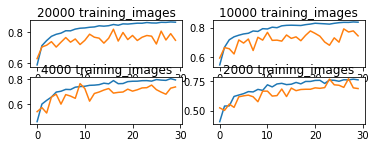

In [8]:
from matplotlib import pyplot

dataset_sizes = [20000, 10000, 4000, 2000]

def add_noise_ortho(img):
    VARIABILITY = 20
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.rot90(img, np.random.choice([-1, 0, 1, 2])) #rotate 0, 90, 180 or 270 degs
    np.clip(img, 0., 255.)
    return img



for i in range(len(dataset_sizes)):
	# determine the plot number
	plot_no = 420 + (i+1)
	pyplot.subplot(plot_no)
	vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                               input_shape=(image_size,image_size,3))

	vgg16.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

	vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

	model_freeze_conv = models.Sequential()
	model_freeze_conv.add(vgg16)
	model_freeze_conv.add(layers.Flatten())
	model_freeze_conv.add(layers.Dense(256, activation = 'relu'))
	model_freeze_conv.add(layers.Dense(num_classes, activation = 'softmax'))

	vgg16.trainable = False

	image_size = 250
	batch_size = 25
	num_train_images = dataset_sizes[i]
	num_valid_images = dataset_sizes[i] // 4
	num_classes = 10

	class_names = ["Amorphophallus", "Fritillaria_th", "Ipomoea", "Kartoffel",
               "Kastanie", "Kichererbse", "Lotus", "Mais", "Reis", "Weizen"]



	#Prepare data-augmenting data generator
	train_datagen = ImageDataGenerator(
	rescale=1./255,
	brightness_range=[0.6,1.4],
	preprocessing_function=add_noise_ortho)

	validation_datagen = ImageDataGenerator(rescale=1./255)

	train_generator = train_datagen.flow_from_directory(
	'./train',
	shuffle = True,
	target_size=(image_size, image_size),
	classes=class_names,
	batch_size=batch_size)

	validation_generator = validation_datagen.flow_from_directory(
	'./validation',
	target_size=(image_size, image_size),
	shuffle = True,
	classes=class_names,
	batch_size=batch_size)

	model_freeze_conv.compile(optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['accuracy'])
	model_freeze_conv.summary()

	name = 'starchID'

	tensorboard_2 = TensorBoard(
	log_dir='./tensorboard/' + name + '/', 
	write_graph=True,
	histogram_freq=0)

	epochs = 30

	history=model_freeze_conv.fit_generator(
	train_generator,
	steps_per_epoch=num_train_images // batch_size,
	epochs=epochs,
	validation_data=validation_generator,
	validation_steps=num_valid_images // batch_size,
	callbacks=[tensorboard_2])

	pyplot.plot(history.history['accuracy'], label='train')
	pyplot.plot(history.history['val_accuracy'], label='test')
	pyplot.title(str(dataset_sizes[i])+  " training_images", pad=-40)
    

# show learning curves
pyplot.show()

# OK, let's get a well performing model for some real predictions (stopping early to avoid overfitting)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=8, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [16]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                          input_shape=(image_size,image_size,3))

model = models.Sequential()
model.add(vgg16)
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(num_classes, activation = 'softmax'))


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dense_2 (Dense)              (None, 7, 7, 256)         131328    
_________________________________________________________________
dense_3 (Dense)              (None, 7, 7, 10)          2570      
Total params: 14,848,586
Trainable params: 14,848,586
Non-trainable params: 0
_________________________________________________________________


In [18]:
image_size = 250
batch_size = 64
num_train_images = 20736
num_valid_images = 5184
num_classes = 10

epochs = 30

history=model_freeze_conv.fit_generator(
        train_generator,
        steps_per_epoch=num_train_images // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_valid_images // batch_size,
        callbacks=[tensorboard_2, early_stopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
324/324 [==============================] - 331s 1s/step - loss: 1.2207 - accuracy: 0.5873 - val_loss: 1.0303 - val_accuracy: 0.6246
Epoch 2/30
324/324 [==============================] - 250s 771ms/step - loss: 0.7751 - accuracy: 0.7224 - val_loss: 0.7779 - val_accuracy: 0.7267
Epoch 3/30
324/324 [==============================] - 250s 770ms/step - loss: 0.6787 - accuracy: 0.7580 - val_loss: 0.7578 - val_accuracy: 0.7357
Epoch 4/30
324/324 [==============================] - 250s 772ms/step - loss: 0.6230 - accuracy: 0.7756 - val_loss: 0.7151 - val_accuracy: 0.7301
Epoch 5/30
324/324 [==============================] - 246s 759ms/step - loss: 0.5566 - accuracy: 0.7997 - val_loss: 0.7398 - val_accuracy: 0.7168
Epoch 6/30
324/324 [==============================] - 261s 806ms/step - loss: 0.5305 - accuracy: 0.8113 - val_loss: 0.8048 - val_accuracy: 0.7012
Epoch 7/30
324/324 [==============================]

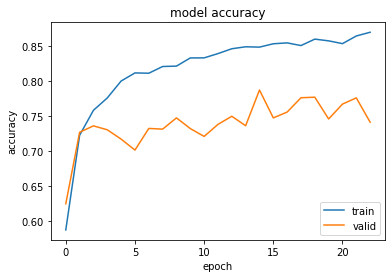

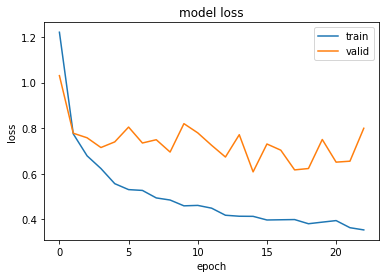

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Save trained model

In [21]:
model_freeze_conv.save('starchID_model4_earlystopped_64_20210118')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: starchID_model4_earlystopped_64_20210118\assets


### Load saved model in case of dead kernel 

In [89]:
from tensorflow import keras
model_freeze_conv = keras.models.load_model('starchID_model4_earlystopped_64_20210115')

## Testing this net on different images (same microscope)

In [22]:
num_test_imgs =13080
num_classes = 10
image_size = 250
class_names = ["Amorphophallus", "Fritillaria_th", "Ipomoea", "Kartoffel",
               "Kastanie", "Kichererbse", "Lotus", "Mais", "Reis", "Weizen"]


test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    directory="./test/",
    target_size=(image_size, image_size),
    batch_size= 1,
    shuffle=False,
)

prediction = model_freeze_conv.predict(test_generator, steps = num_test_imgs)

Found 13080 images belonging to 10 classes.


In [23]:
#prediction2 = prediction * 100
#np.set_printoptions(suppress=True)
# inspect predictions
#prediction2[327]

In [24]:
# get predicted classes and ground truth
y_true = test_generator.classes
y_pred = np.rint(prediction)

In [25]:
Y_valid = np.zeros((num_test_imgs,1),dtype=int)

step = num_test_imgs // num_classes
for ind in range(num_classes):
    y_true[ind*step:(ind+1)*step] = ind
    
confmat = confusion_matrix(y_true,np.argmax(prediction,axis=1))   

for i0 in range(num_classes):
    sys.stdout.write('[')
    for i1 in range(num_classes):
        sys.stdout.write('{:3d} '.format(confmat[i0,i1]))
    
    sys.stdout.write('], {}\n'.format(class_names[i0]))
    
sys.stdout.flush()



[1177   0  44   0   0   0   3   1  83   0 ], Amorphophallus
[  0 1220  48  20   0   2   9   0   9   0 ], Fritillaria_th
[  6 352 861   5   0   4  12   8  57   3 ], Ipomoea
[  0 198  10 961   0  93  29   4   4   9 ], Kartoffel
[  0   2   0   0 1252   5  14   1   0  34 ], Kastanie
[  0 212  10  77   2 942  25   5   1  34 ], Kichererbse
[  4 139  22  46  22  94 922  21   4  34 ], Lotus
[  0  56  31  17   2 167  48 979   2   6 ], Mais
[ 41  26 104  14   0   0  21  15 1087   0 ], Reis
[  0 188  13  34  34  60  57   1   0 921 ], Weizen


# Confusion matrix heat map

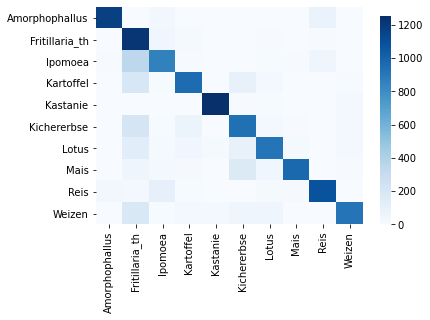

In [26]:
import seaborn as sns
ax = sns.heatmap(confmat, cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
ax.collections[0].colorbar.ax.set_ylim(0,(num_test_imgs // num_classes))
plt.show()

# Inspect correct/wrong classifications

In [159]:
# Choose the class label you want to check
clbl = 9
step = num_test_imgs // num_classes
pred_labels = np.argmax(prediction[clbl*step:(clbl+1)*step],axis=1)
wrong_labels = np.transpose(np.nonzero(pred_labels != clbl))

wrong classification for: Weizen


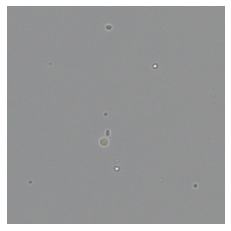

matched to: Fritillaria_th


In [162]:
print('wrong classification for: {}'.format(class_names[clbl]))
x = random.choice(range(len(wrong_labels)))
img = test_generator[clbl*step+x][0][0]
plot_img(img.reshape(250,250,3))
print('matched to: {}'.format(class_names[pred_labels[int(wrong_labels[x])]]))

Of course this doesn't work!

### Some classification errors and their possible causes....:


- Class 0: Amorphophallus mistaken for Reis (and vice verse): apparent sample cross-contamination (?)
    --> Model work quite well if it detect sloppy handling on my part!!

- Class 1: Fritillaria_th mistaken for Lotus: "blank" image

- Class 2: Ipomoea mistaken for Fritillaria: just debris visible

- Class 3: Kartoffel mistaken for Fritillaria: only small (unspecific) grains visible

- Class 4: Kastanie mistaken for Lotus: ?

- Class 5: Kichererbse mistaken for Kartoffel: only small (unspecific) grains visible

- Class 6: Lotus mistaken for Kartoffel: sometimes only small (unspecific) grains visible, sometimes visual artefacts

- Class 7: Mais mistaken for Kichererbse: sometimes only small (unspecific) grains visible, sometimes visual artefacts

- Class 8: Reis mistaken for Amorphophallus (and vice verse): apparent sample cross-contamination (?)

- Class 9: Weizen mistaken for fritillaria_th: only small (unspecific) grains visible


# Quick shot bonus: Testing model using images from another microscope

In [163]:
num_test_imgs =450
num_classes = 10
image_size = 250
class_names = ["Amorphophallus", "Fritillaria_th", "Ipomoea", "Kartoffel",
               "Kastanie", "Kichererbse", "Lotus", "Mais", "Reis", "Weizen"]


test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    directory="./test_other_mic/",
    target_size=(image_size, image_size),
    batch_size= 1,
    shuffle=False,
)

prediction = model_freeze_conv.predict(test_generator, steps = num_test_imgs)

Found 450 images belonging to 10 classes.


In [164]:
# get predicted classes and ground truth
y_true = test_generator.classes
y_pred = np.rint(prediction)

In [165]:
Y_valid = np.zeros((num_test_imgs,1),dtype=int)

step = num_test_imgs // num_classes
for ind in range(num_classes):
    y_true[ind*step:(ind+1)*step] = ind
    
confmat = confusion_matrix(y_true,np.argmax(prediction,axis=1))   

for i0 in range(num_classes):
    sys.stdout.write('[')
    for i1 in range(num_classes):
        sys.stdout.write('{:3d} '.format(confmat[i0,i1]))
    
    sys.stdout.write('], {}\n'.format(class_names[i0]))
    
sys.stdout.flush()


[  2   0   4   0   7   0  23   4   5   0 ], Amorphophallus
[  0   0   7  18   0   2   0   0  18   0 ], Fritillaria_th
[  0   4  10   0   1  10  13   7   0   0 ], Ipomoea
[  0  11   5  23   0   0   1   0   5   0 ], Kartoffel
[  0   1   3   0  22   0  19   0   0   0 ], Kastanie
[  0   1  14  10   0   2   0   3  15   0 ], Kichererbse
[  1   1   2   0   0   0  40   0   1   0 ], Lotus
[  1   0   8   0   0   0   0  17  19   0 ], Mais
[  0   0   0   0   0   5   9  25   3   3 ], Reis
[  0   0   1   0  25   0  19   0   0   0 ], Weizen


# Slightly better than random  ¯\\_(ツ)_/¯

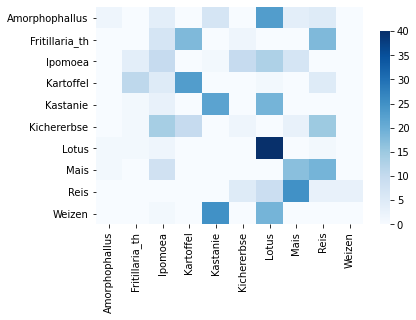

In [166]:
import seaborn as sns
ax = sns.heatmap(confmat, cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
ax.collections[0].colorbar.ax.set_ylim(0,(num_test_imgs // num_classes))
plt.show()

# Conclusions

- On the same microscope-system: Accuracy of about 80% with 10 classes!
- Many false classifications are based on rubbish-images with no features (maybe 500x500 pixels is too small?)
- Very high accuracy could be acheived by majority vote of e.g. 3 different images
- Performance across different microscopes seems rather bad. This is not unexpected and may be, amongst other reasons, due to the fact that no exact resizing (pixels / micrometer) was done!!
- Including different microscopes in the training data might dramatically improve generalisation of the model.
- If used accross microscopes: Image segmentation prior to modelling might be the key...
- Working with my own GPU was tough to set up but fun as soon as it worked.
- Thing to try:
    - Rotation through datagen
    - Fine-tuning
    - Image segmentation prior to modeling (Mask-RCNN, etc)


# Misc stuff (trying dropout layers, which apperas to have no effect)

## Test dropout on hidden layer (0.1)

Found 20940 images belonging to 10 classes.
Found 5235 images belonging to 10 classes.
Epoch 1/50
324/324 [==============================] - 245s 756ms/step - loss: 1.4797 - accuracy: 0.4997 - val_loss: 1.0264 - val_accuracy: 0.6242
Epoch 2/50
324/324 [==============================] - 245s 757ms/step - loss: 0.9861 - accuracy: 0.6447 - val_loss: 0.8598 - val_accuracy: 0.6860
Epoch 3/50
324/324 [==============================] - 246s 758ms/step - loss: 0.8855 - accuracy: 0.6798 - val_loss: 0.8220 - val_accuracy: 0.7178
Epoch 4/50
324/324 [==============================] - 244s 755ms/step - loss: 0.8230 - accuracy: 0.6947 - val_loss: 0.8191 - val_accuracy: 0.7141
Epoch 5/50
324/324 [==============================] - 246s 758ms/step - loss: 0.7938 - accuracy: 0.7117 - val_loss: 0.8375 - val_accuracy: 0.7037
Epoch 6/50
324/324 [==============================] - 245s 755ms/step - loss: 0.7453 - accuracy: 0.7238 - val_loss: 0.7342 - val_accuracy: 0.7384
Epoch 7/50
324/324 [=================

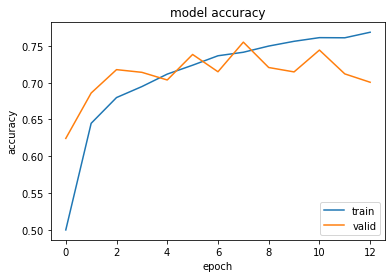

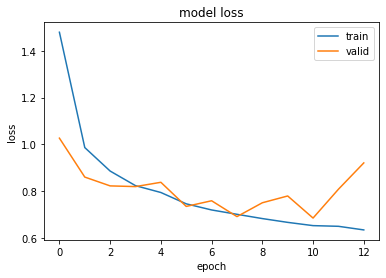

In [43]:
from matplotlib import pyplot

dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
i=1

def add_noise_ortho(img):
    VARIABILITY = 20
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.rot90(img, np.random.choice([-1, 0, 1, 2])) #rotate 0, 90, 180 or 270 degs
    np.clip(img, 0., 255.)
    return img




#for i in range(len(dataset_sizes)):
# determine the plot number
#plot_no = 420 + (i+1)
#pyplot.subplot(plot_no)
vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

vgg16.trainable = False

model_freeze_conv = models.Sequential()
model_freeze_conv.add(vgg16)
model_freeze_conv.add(layers.Flatten())
model_freeze_conv.add(layers.Dense(256, activation = 'relu'))
model_freeze_conv.add(Dropout(dropout_rate[i]))
model_freeze_conv.add(layers.Dense(num_classes, activation = 'softmax'))


model_freeze_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

image_size = 250
batch_size = 64
num_train_images = 20736
num_valid_images = 5184
num_classes = 50

class_names = ["Amorphophallus", "Fritillaria_th", "Ipomoea", "Kartoffel",
               "Kastanie", "Kichererbse", "Lotus", "Mais", "Reis", "Weizen"]



#Prepare data-augmenting data generator
train_datagen = ImageDataGenerator(
rescale=1./255,
brightness_range=[0.6,1.4],
preprocessing_function=add_noise_ortho)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
'./train',
shuffle = True,
target_size=(image_size, image_size),
classes=class_names,
batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
'./validation',
target_size=(image_size, image_size),
shuffle = True,
classes=class_names,
batch_size=batch_size)

model_freeze_conv.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

name = 'starchID'

tensorboard_2 = TensorBoard(
log_dir='./tensorboard/' + name + '/', 
write_graph=True,
histogram_freq=0)

epochs = 50

history=model_freeze_conv.fit_generator(
train_generator,
steps_per_epoch=num_train_images // batch_size,
epochs=epochs,
validation_data=validation_generator,
validation_steps=num_valid_images // batch_size,
callbacks=[tensorboard_2, early_stopping])


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()


#pyplot.plot(history.history['accuracy'], label='train')
#pyplot.plot(history.history['val_accuracy'], label='test')
#pyplot.title(str(dropout_rate[i])+  "% dropout", pad=-40)
    

# show learning curves
#pyplot.show()

In [59]:
model_freeze_conv.save('starchID_model_freze_conv_dropout01 20210115')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: starchID_model_freze_conv_dropout01 20210115\assets


## Test dropout on hidden layer (0.2)

Found 20940 images belonging to 10 classes.
Found 5235 images belonging to 10 classes.
Epoch 1/50
324/324 [==============================] - 366s 1s/step - loss: 1.4035 - accuracy: 0.5057 - val_loss: 1.0607 - val_accuracy: 0.6279
Epoch 2/50
324/324 [==============================] - 322s 994ms/step - loss: 1.0142 - accuracy: 0.6340 - val_loss: 0.9377 - val_accuracy: 0.6516
Epoch 3/50
324/324 [==============================] - 261s 807ms/step - loss: 0.9235 - accuracy: 0.6618 - val_loss: 0.8202 - val_accuracy: 0.7301
Epoch 4/50
324/324 [==============================] - 253s 781ms/step - loss: 0.8568 - accuracy: 0.6837 - val_loss: 0.8908 - val_accuracy: 0.6779
Epoch 5/50
324/324 [==============================] - 255s 787ms/step - loss: 0.8241 - accuracy: 0.7011 - val_loss: 0.7637 - val_accuracy: 0.7290
Epoch 6/50
324/324 [==============================] - 252s 776ms/step - loss: 0.8004 - accuracy: 0.7077 - val_loss: 0.8195 - val_accuracy: 0.7120
Epoch 7/50
324/324 [====================

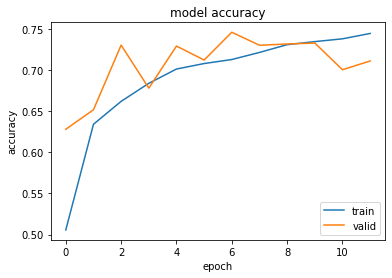

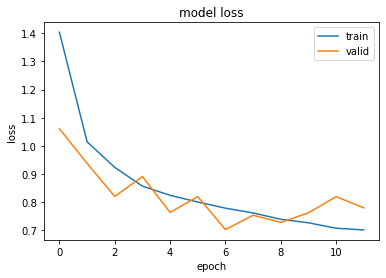

In [60]:
from matplotlib import pyplot

dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
i=2

def add_noise_ortho(img):
    VARIABILITY = 20
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.rot90(img, np.random.choice([-1, 0, 1, 2])) #rotate 0, 90, 180 or 270 degs
    np.clip(img, 0., 255.)
    return img




#for i in range(len(dataset_sizes)):
# determine the plot number
#plot_no = 420 + (i+1)
#pyplot.subplot(plot_no)
vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

vgg16.trainable = False

model_freeze_conv = models.Sequential()
model_freeze_conv.add(vgg16)
model_freeze_conv.add(layers.Flatten())
model_freeze_conv.add(layers.Dense(256, activation = 'relu'))
model_freeze_conv.add(Dropout(dropout_rate[i]))
model_freeze_conv.add(layers.Dense(num_classes, activation = 'softmax'))


model_freeze_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

image_size = 250
batch_size = 64
num_train_images = 20736
num_valid_images = 5184
num_classes = 50

class_names = ["Amorphophallus", "Fritillaria_th", "Ipomoea", "Kartoffel",
               "Kastanie", "Kichererbse", "Lotus", "Mais", "Reis", "Weizen"]



#Prepare data-augmenting data generator
train_datagen = ImageDataGenerator(
rescale=1./255,
brightness_range=[0.6,1.4],
preprocessing_function=add_noise_ortho)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
'./train',
shuffle = True,
target_size=(image_size, image_size),
classes=class_names,
batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
'./validation',
target_size=(image_size, image_size),
shuffle = True,
classes=class_names,
batch_size=batch_size)

model_freeze_conv.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

name = 'starchID'

tensorboard_2 = TensorBoard(
log_dir='./tensorboard/' + name + '/', 
write_graph=True,
histogram_freq=0)

epochs = 50

history=model_freeze_conv.fit_generator(
train_generator,
steps_per_epoch=num_train_images // batch_size,
epochs=epochs,
validation_data=validation_generator,
validation_steps=num_valid_images // batch_size,
callbacks=[tensorboard_2, early_stopping])


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()


#pyplot.plot(history.history['accuracy'], label='train')
#pyplot.plot(history.history['val_accuracy'], label='test')
#pyplot.title(str(dropout_rate[i])+  "% dropout", pad=-40)
    

# show learning curves
#pyplot.show()

In [61]:
model_freeze_conv.save('starchID_model_freze_conv_dropout02 20210115')

INFO:tensorflow:Assets written to: starchID_model_freze_conv_dropout02 20210115\assets


## Test dropout on output layer (0.3)

Found 20940 images belonging to 10 classes.
Found 5235 images belonging to 10 classes.
Epoch 1/50
324/324 [==============================] - 271s 838ms/step - loss: 1.6519 - accuracy: 0.3962 - val_loss: 1.2301 - val_accuracy: 0.5554
Epoch 2/50
324/324 [==============================] - 271s 835ms/step - loss: 1.2948 - accuracy: 0.5140 - val_loss: 1.0235 - val_accuracy: 0.6564
Epoch 3/50
324/324 [==============================] - 269s 831ms/step - loss: 1.1912 - accuracy: 0.5562 - val_loss: 1.0921 - val_accuracy: 0.6128
Epoch 4/50
324/324 [==============================] - 268s 828ms/step - loss: 1.1158 - accuracy: 0.5827 - val_loss: 0.9314 - val_accuracy: 0.6684
Epoch 5/50
324/324 [==============================] - 267s 825ms/step - loss: 1.0815 - accuracy: 0.5933 - val_loss: 0.8406 - val_accuracy: 0.6944
Epoch 6/50
324/324 [==============================] - 268s 828ms/step - loss: 1.0677 - accuracy: 0.6026 - val_loss: 0.8699 - val_accuracy: 0.7093
Epoch 7/50
324/324 [=================

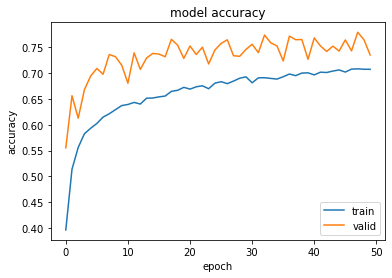

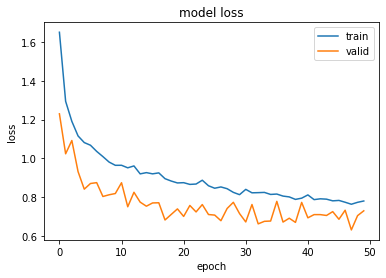

In [88]:

from matplotlib import pyplot

dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
i=3

def add_noise_ortho(img):
    VARIABILITY = 20
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.rot90(img, np.random.choice([-1, 0, 1, 2])) #rotate 0, 90, 180 or 270 degs
    np.clip(img, 0., 255.)
    return img




#for i in range(len(dataset_sizes)):
# determine the plot number
#plot_no = 420 + (i+1)
#pyplot.subplot(plot_no)
vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

vgg16.trainable = False

model_freeze_conv = models.Sequential()
model_freeze_conv.add(vgg16)
model_freeze_conv.add(layers.Flatten())
model_freeze_conv.add(layers.Dense(256, activation = 'relu'))
model_freeze_conv.add(Dropout(dropout_rate[i]))
model_freeze_conv.add(layers.Dense(num_classes, activation = 'softmax'))


model_freeze_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

image_size = 250
batch_size = 64
num_train_images = 20736
num_valid_images = 5184
num_classes = 50

class_names = ["Amorphophallus", "Fritillaria_th", "Ipomoea", "Kartoffel",
               "Kastanie", "Kichererbse", "Lotus", "Mais", "Reis", "Weizen"]



#Prepare data-augmenting data generator
train_datagen = ImageDataGenerator(
rescale=1./255,
brightness_range=[0.6,1.4],
preprocessing_function=add_noise_ortho)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
'./train',
shuffle = True,
target_size=(image_size, image_size),
classes=class_names,
batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
'./validation',
target_size=(image_size, image_size),
shuffle = True,
classes=class_names,
batch_size=batch_size)

model_freeze_conv.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

name = 'starchID'

tensorboard_2 = TensorBoard(
log_dir='./tensorboard/' + name + '/', 
write_graph=True,
histogram_freq=0)

epochs = 50

history=model_freeze_conv.fit_generator(
train_generator,
steps_per_epoch=num_train_images // batch_size,
epochs=epochs,
validation_data=validation_generator,
validation_steps=num_valid_images // batch_size,
callbacks=[tensorboard_2])


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()


#pyplot.plot(history.history['accuracy'], label='train')
#pyplot.plot(history.history['val_accuracy'], label='test')
#pyplot.title(str(dropout_rate[i])+  "% dropout", pad=-40)
    

# show learning curves
#pyplot.show()

In [ ]:
model_freeze_conv.save('starchID_model_freze_conv_dropout03 20210115')